# Importing Libraries and Cleaned Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as stats
from sklearn import linear_model, feature_selection, metrics, model_selection, impute, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

county_health_rank = pd.read_csv('county_rankings25.csv')
qol_22 = pd.read_csv('QOL.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
race_groups = pd.read_csv('agg_race_variables.csv')

In [2]:
county_health_rank.shape

(3204, 796)

In [3]:
nulls = county_health_rank.isna().sum()

In [4]:
nulls.shape

(796,)

# Data Cleaning Plan
## County Health Rankings 2025
The Dataset 'County Health Rankings 2025' jas 3204 rows and 796 columms. The columns report socio economic metrics from all counties in the US. These metrics are unstacked with confidence intervals as columns adjacent to raw estimates. Some metrics report at a county level only, whilst others alos report racial group breakdows next to the totals. Though it is a comprehensive dataset, like most of its kind, there is much missing data, especially for minority groups, with communities like Native Hawaiian or Pacific Islander not appearing at all in a majority of counties. 

The data wrangling process will involve: created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions, using a funciton to select the target variables, renaming, and normalizing data types. I will, then, validate the resulting dataframe, and applying the standardized hierarchical index (county, state).

Note: much of the numeric data is in percentages, separate subsets will include totals and percentages and will be used depending on type of analysis and indexing needed.
## Quality of Life Data 2022
Since this study began with this study and happened to contain data for the US 2020 General Election at a county level, I will subset that category and merge with the table above. 
## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

## Groupings and Subsets
Depending on the structure of the final merge, I may use smaller subsets and/or different data structures and groupings for specialized analysis and testing .

# Data Cleaning

## County Rankings tables

### Make Subset Function

In [5]:
# defining variable for function to select target vars, dictionary to rename, and set 'fips' as 'str' dtype
county_health_subset = county_vars['raw_variable'].tolist()
county_name_list = county_vars[' new_name'].tolist()
county_new_names = dict(zip(county_health_subset, county_name_list))

In [6]:
def make_subset(df, target_vars, target_names):
    df = df[target_vars]
    df = df.rename(columns=target_names) #dictionary defined from target variables & names list
    df['fips'] = df['fips'].astype('str')
    return df

In [7]:
counties = make_subset(county_health_rank, county_health_subset, county_new_names)

### Clean colums function

In [8]:
# list of state names from master fips to drop from county namers column
state_names = fips_codes['state'].unique()
state_names = state_names.tolist()
state_names.append('United States')
# variable name referring to state 
def clean_subset(df):
    df = df[~df['county'].isin(state_names)]
    df = df.round(3)
    return df

In [9]:
counties = clean_subset(counties)

## QOL- Political Party 2020

In [10]:
qol_target_vars = ['2020PopulrVoteParty', 'NMCNTY', 'FIPS', 'LSTATE']
qol_new_names = {'2020PopulrVoteParty': 'political_party', 'NMCNTY':'county', 'FIPS':'fips', 'LSTATE':'state_abbr'}

In [11]:
pol_party_2020 = make_subset(qol_22, qol_target_vars, qol_new_names)

## subsets and groupings for drill-down analysis 

## Variable-based subsets

In [12]:
inequity_vars = ['state_abbr','county','fips', 'income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap']
# Socio-economic indicators with racial breakdown
racial_category_subset = race_groups['raw_variable'].tolist()
racial_category_names = race_groups['new_name'].tolist()
racial_category_cols = dict(zip(racial_category_subset, racial_category_names))

In [13]:
# cleaning and reshaping dataframe with variable containing racial-breakdowns
race_subset = make_subset(county_health_rank, racial_category_subset, racial_category_cols)
counties_race = clean_subset(race_subset)
# reshape dataframe
# Melt the dataframe to long format
counties_race = counties_race.melt(
    id_vars=['state_abbr', 'county', 'fips', 'county_population'], 
    var_name='metric_race', 
    value_name='value'
)

# Split the combined 'metric_ethnicity' column
counties_race[['metric', 'race']] = counties_race['metric_race'].str.extract(r'(.+?)-(.+)')

# Drop the original combined column
counties_race = counties_race.drop(columns='metric_race')

# Pivot to have metrics as columns
counties_race = counties_race.pivot_table(
    index=['state_abbr', 'county', 'fips', 'race', 'county_population'],
    columns='metric',
    values='value'
).reset_index()

# Clean up column names if needed
counties_race.columns.name = None

### County-Level socio-economic outcomes (no racial breakdown)

In [14]:
aggregate_outcomes = counties.drop(columns=['child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'premature_death'])
agg_vars = aggregate_outcomes.columns.to_list()
agg_vars.append('political_party')

## Total Values (vs percentages)

In [15]:
pop_vars = ['state_abbr','county','fips', 'population']
county_pop = counties[pop_vars]
# find columns w percentage ouputs by assigining target string to variable ans using lamda  func to filter col names and assign to list
percent_str = 'percentage'
percent_vars = list(filter(lambda x: percent_str in x, county_name_list))
counties_totals = counties.copy()
counties_pop_col = 'population'

#### totals function

In [16]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_total_pop(df, cols, pop_col):
    for i in df[cols]:
        df[i] = df[i] * df[pop_col]
    df.columns = df.columns.str.replace('_percentage', '')
    return df

In [ ]:
counties_totals= calc_total_pop(counties_totals, percent_vars, counties_pop_col)

### Totals- broken down by race

In [17]:
race_pop_col = 'county_population'
race_percentage_vars = [ 'population_percentage', 'child_poverty_percentage']
racial_breakdown_total = counties_race.copy()
counties_race_totals = calc_total_pop(racial_breakdown_total, race_percentage_vars, race_pop_col)

Note: Many missing values

## Merge for Analysis

In [18]:
fips_codes['fips'] = fips_codes['fips'].astype('str')
index = ['state_abbr', 'county', 'fips']
fips_codes.reset_index(inplace=True)
pol_party_2020.reset_index(inplace=True) #state_abbr
counties.reset_index(inplace=True) #state_abbr
# setting common indices

### Merge dataframes using 'state' with 'fact' table ('all_fips') and set indices for uniform id variables

In [19]:
fips_codes.set_index(index)
pol_party_2020.set_index(index)
counties.set_index(index)
pol_party_indexed = pd.merge(pol_party_2020, fips_codes, on=index, how='inner')
counties_indexed = pd.merge(counties, fips_codes, on=index, how='inner')

In [ ]:
pol_party_indexed= pol_party_indexed.drop(columns='state')
counties_indexed= counties_indexed.drop(columns='state')
counties_pol_party = counties_indexed.merge(pol_party_indexed, how='left', on=index)

### Merge counties and pol_party df's on common multi-index

In [25]:
# function to clean merged tables
def clean_merged(df):
    # Drop duplicate rows in column: 'fips'
    df = df.drop_duplicates(subset='fips')
    df = df[~df['county'].isin(state_names)]
    df = df.round(3)
    return df

In [26]:
counties_pol_party = clean_merged(counties_pol_party)
counties_pol_party.reset_index()

,index,index_x_x,fips,county,state_abbr,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,...,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden,index_y_x,index_x_y,political_party,index_y_y
0,0,2,1001,Autauga County,AL,0.903,0.022,60342.0,68857.0,0.058,...,0.170,74.801,61.256,0.117,17.454,0.218,29,2263.0,R,29.0
1,1,3,1003,Baldwin County,AL,0.917,0.023,253507.0,74248.0,0.086,...,0.141,76.580,50.158,0.101,14.962,0.194,30,2628.0,R,30.0
2,2,4,1005,Barbour County,AL,0.778,0.044,24585.0,45298.0,0.036,...,0.348,72.709,71.707,0.095,26.650,0.286,31,1313.0,R,31.0
3,3,5,1007,Bibb County,AL,0.803,0.025,21868.0,56025.0,0.090,...,0.214,72.977,87.077,0.091,21.542,0.266,32,1941.0,R,32.0
4,4,6,1009,Blount County,AL,0.827,0.021,59816.0,64962.0,0.094,...,0.166,72.936,58.036,0.075,18.145,0.253,33,2351.0,R,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,3119,3199,56037,Sweetwater County,WY,0.925,0.033,41249.0,76442.0,0.033,...,0.115,74.630,61.743,0.085,27.485,0.245,3138,2246.0,R,3138.0
3120,3120,3200,56039,Teton County,WY,0.972,0.021,23232.0,130156.0,0.078,...,0.057,87.577,66.916,0.120,14.542,0.193,3139,1422.0,R,3139.0
3121,3121,3201,56041,Uinta County,WY,0.946,0.032,20745.0,79086.0,0.050,...,0.114,74.946,65.020,0.062,20.571,0.176,3140,1696.0,R,3140.0
3122,3122,3202,56043,Washakie County,WY,0.914,0.033,7710.0,62794.0,0.044,...,0.173,76.072,NaN,0.068,NaN,0.270,3141,576.0,R,3141.0


In [32]:
counties_pol_party.to_csv('counties_pol_party.csv')

## Create combined dataframe with county-level variables and variables broken down by race 

Subset merged df with variables for aggregate data (not contained in race dataframe) to avoid duplicate columns

In [27]:
test_agg = counties_pol_party[agg_vars]
all_sets= counties_race.merge(test_agg, how='left', on=index)
all_sets.set_index(['state_abbr', 'county', 'fips','race'], inplace=True)

In [28]:
all_sets.reset_index(inplace=True)
all_sets['race'] = all_sets['race'].astype('category')

In [29]:
all_sets.reset_index()

,index,state_abbr,county,fips,race,county_population,child_mortality,child_poverty_percentage,firearm_fatalities,life_expectancy,...,population,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,income_inequality,high_housing_cost_percentage,child_care_cost_burden,political_party
0,0,AK,Aleutians East Borough,2013,aian,3461.0,NaN,0.263,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
1,1,AK,Aleutians East Borough,2013,asian,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
2,2,AK,Aleutians East Borough,2013,black,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
3,3,AK,Aleutians East Borough,2013,hispanic,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
4,4,AK,Aleutians East Borough,2013,nhopi,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18853,18853,WY,Weston County,56045,asian,6808.0,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R
18854,18854,WY,Weston County,56045,black,6808.0,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R
18855,18855,WY,Weston County,56045,hispanic,6808.0,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R
18856,18856,WY,Weston County,56045,nhopi,6808.0,NaN,NaN,NaN,NaN,...,6808.0,0.023,0.513,0.146,4071.35,NaN,4.174,0.096,0.231,R


## Address Missing Data 

### Aggregate data

In [30]:
missing = counties_pol_party.isnull().sum()
print(missing)

index_x_x                          0
fips                               0
county                             0
state_abbr                         0
hs_diploma_percentage              8
unemployed_percentage              1
population                         8
median_income                      9
school_segration_index           221
gender_pay_gap                    16
uninsured__percentage              9
school_funding_gap                81
residential_segregation         1076
premature_death                   52
income_inequality                 29
child_poverty_percentage           9
life_expectancy                   72
child_mortality                 1086
high_housing_cost_percentage       8
firearm_fatalities               838
child_care_cost_burden             2
index_y_x                          0
index_x_y                          4
political_party                    4
index_y_y                          4
dtype: int64


In [31]:
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

#### Use KNN Imputation to address missing data

In [33]:
non_numeric_cols = ['state_abbr', 'county', 'fips', 'political_party']
counties_numeric_cols = ['hs_diploma_percentage',
       'unemployed_percentage', 'population', 'median_income',
       'school_segration_index', 'gender_pay_gap', 'uninsured__percentage',
       'school_funding_gap', 'residential_segregation', 'premature_death',
       'income_inequality', 'child_poverty_percentage', 'life_expectancy',
       'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities',
       'child_care_cost_burden']

In [34]:
imputer = KNNImputer(n_neighbors=2)
# running inputation for numeric columns only
countypol_sets_numeric = pd.DataFrame(imputer.fit_transform(counties_pol_party[counties_numeric_cols]), columns=counties_numeric_cols)
# concatenating to non0numeric columns to recreate entire df
countypol_filled = pd.concat([counties_pol_party[non_numeric_cols].reset_index(drop=True), countypol_sets_numeric], axis=1)

### hierachical dataframe- brokendown by race
There is a great deal of missing data for racial categories, handling missing data will differ from above

In [36]:
all_sets_missing = all_sets.isnull().sum()

In [37]:
# drop missing population values- indicates no county reporting for racial group
# too much missing data for imputation to entire seet- median income has highest reporting for racial groups
all_sets = all_sets.dropna(subset=['population','median_income'])
# dropping colums w more than half of records missing
#all_sets = all_sets.drop(columns=['firearm_fatalities', 'child_mortality'])
all_sets.reset_index()

,index,state_abbr,county,fips,race,county_population,child_mortality,child_poverty_percentage,firearm_fatalities,life_expectancy,...,population,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,income_inequality,high_housing_cost_percentage,child_care_cost_burden,political_party
0,0,AK,Aleutians East Borough,2013,aian,3461.0,NaN,0.263,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
1,1,AK,Aleutians East Borough,2013,asian,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
2,3,AK,Aleutians East Borough,2013,hispanic,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
3,5,AK,Aleutians East Borough,2013,white,3461.0,NaN,NaN,NaN,NaN,...,3461.0,NaN,1.071,0.196,NaN,NaN,4.733,0.085,0.216,R
4,6,AK,Aleutians West Census Area,2016,aian,5160.0,NaN,0.124,NaN,NaN,...,5160.0,0.204,0.709,0.167,NaN,NaN,3.134,0.036,0.312,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9801,18843,WY,Uinta County,56041,hispanic,20745.0,NaN,0.039,NaN,81.762,...,20745.0,0.050,0.630,0.137,7141.453,NaN,3.672,0.062,0.176,R
9802,18845,WY,Uinta County,56041,white,20745.0,59.341,0.068,22.529,74.738,...,20745.0,0.050,0.630,0.137,7141.453,NaN,3.672,0.062,0.176,R
9803,18849,WY,Washakie County,56043,hispanic,7710.0,NaN,0.139,NaN,NaN,...,7710.0,0.044,0.752,0.150,13314.790,NaN,4.765,0.068,0.270,R
9804,18851,WY,Washakie County,56043,white,7710.0,NaN,0.123,NaN,76.417,...,7710.0,0.044,0.752,0.150,13314.790,NaN,4.765,0.068,0.270,R


#### see categorical descriptions

In [38]:
print(all_sets.groupby('race').describe())

         county_population                                                  \
                     count           mean            std     min       25%   
race                                                                         
aian                1282.0  208923.229329  496844.269766   765.0  24264.25   
asian               1291.0  225496.721146  492683.668053  1095.0  36305.50   
black               1752.0  172955.369863  432105.235922  1294.0  21690.75   
hispanic            2370.0  134355.617722  377424.233239   568.0  15496.75   
nhopi                  0.0            NaN            NaN     NaN       NaN   
white               3111.0  105963.877853  333373.423205    43.0  10821.50   

                                        child_mortality              ...  \
              50%        75%        max           count        mean  ...   
race                                                                 ...   
aian      59679.0  183202.25  9663345.0            54.0  139.451796  

- nhopi missig summary stats across all metrics- will drop this category 

In [39]:
all_sets['race'] = all_sets['race'].cat.remove_categories('nhopi')

#### Data Imputation
after removing mostly incomplete columns and categories, same KNN imputation will be used 

In [40]:
numeric_cols = ['county_population',
       'child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'population_percentage',
       'premature_death', 'hs_diploma_percentage', 'unemployed_percentage',
       'population', 'school_segration_index', 'gender_pay_gap',
       'uninsured__percentage', 'school_funding_gap',
       'residential_segregation', 'income_inequality',
       'high_housing_cost_percentage', 'child_care_cost_burden']

imputer = KNNImputer(n_neighbors=2)
all_sets_numeric = pd.DataFrame(imputer.fit_transform(all_sets[numeric_cols]), columns= numeric_cols)
all_sets_filled = pd.concat([all_sets[non_numeric_cols].reset_index(drop=True), all_sets_numeric], axis=1)

In [ ]:
all_sets_filled.head()

### Standardizing Values

In [41]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
#standardize_frame = counties[vars_to_z]
standardized_frame = counties_pol_party.dropna()
standardized_all_filled = all_sets_filled.copy()

In [42]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [43]:
z_counties= calc_z(countypol_filled, counties_numeric_cols)
z_all_sets_filled= calc_z(all_sets_filled, numeric_cols)

# Insights

## Mutual Information: finding highly dependent Variables

### County-Level

#### Creating a Matrix of pairs fo each dependent var w independent var

Attempted model with KNN inputation and results were drastically different, thus rejected inputed values as overwhlmingly affecting dta integrity. therefore attempting original data with dropped missing values

In [44]:
counties_pol_raw = counties_pol_party.dropna()

In [45]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_raw[[var1]]
        y = counties_pol_raw[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.108576               0.075040   
gender_pay_gap                        0.048092               0.003181   
school_segration_index                0.030676               0.043209   
residential_segregation               0.048182               0.012070   
school_funding_gap                    0.222867               0.033826   

                         population  median_income  uninsured__percentage  \
income_inequality          0.026886       0.209483               0.074442   
gender_pay_gap             0.074451       0.026369               0.029625   
school_segration_index     0.182791       0.026908               0.005947   
residential_segregation    0.080663       0.021658               0.071215   
school_funding_gap         0.088501       0.249666               0.248828   

                         premature_death  child_poverty_percentage  \
income_inequality           

#### Visualizing Pairwise Mutual Information as Heatmap

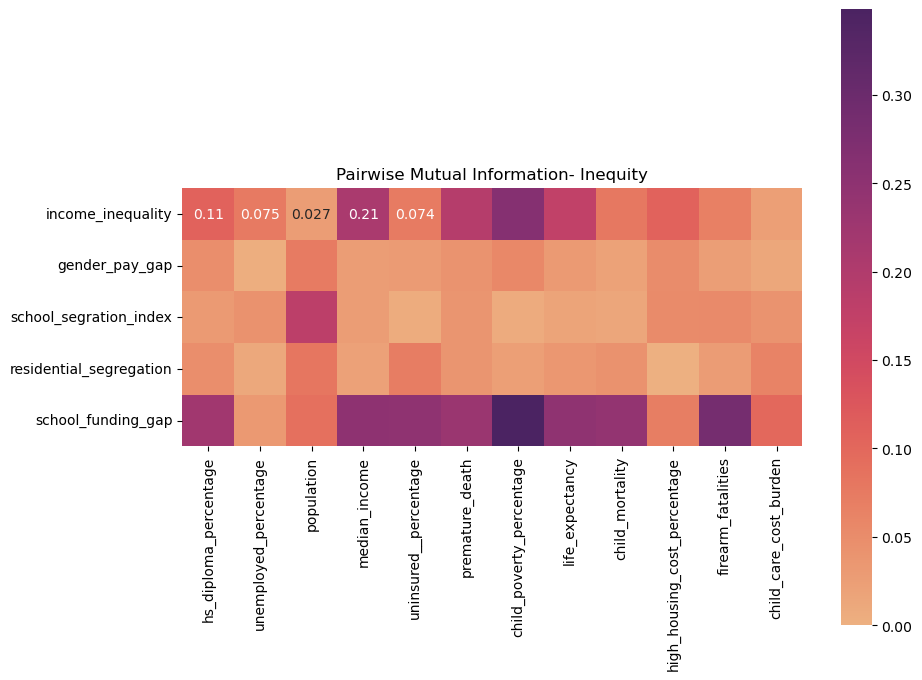

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='flare', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

#### Getting top values of dependent pairs

In [47]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap        0.348527
firearm_fatalities        school_funding_gap        0.286294
child_poverty_percentage  income_inequality         0.262798
median_income             school_funding_gap        0.249666
uninsured__percentage     school_funding_gap        0.248828
life_expectancy           school_funding_gap        0.248642
child_mortality           school_funding_gap        0.242570
premature_death           school_funding_gap        0.232733
hs_diploma_percentage     school_funding_gap        0.222867
median_income             income_inequality         0.209483
premature_death           income_inequality         0.192511
population                school_segration_index    0.182791
dtype: float64


### Selecting most 'infromative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

In [48]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_raw[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality'],
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

## Correlation and Covariance

In [ ]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='flare')

### Correlations between selected explainer and selected outcome variables

In [49]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [50]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


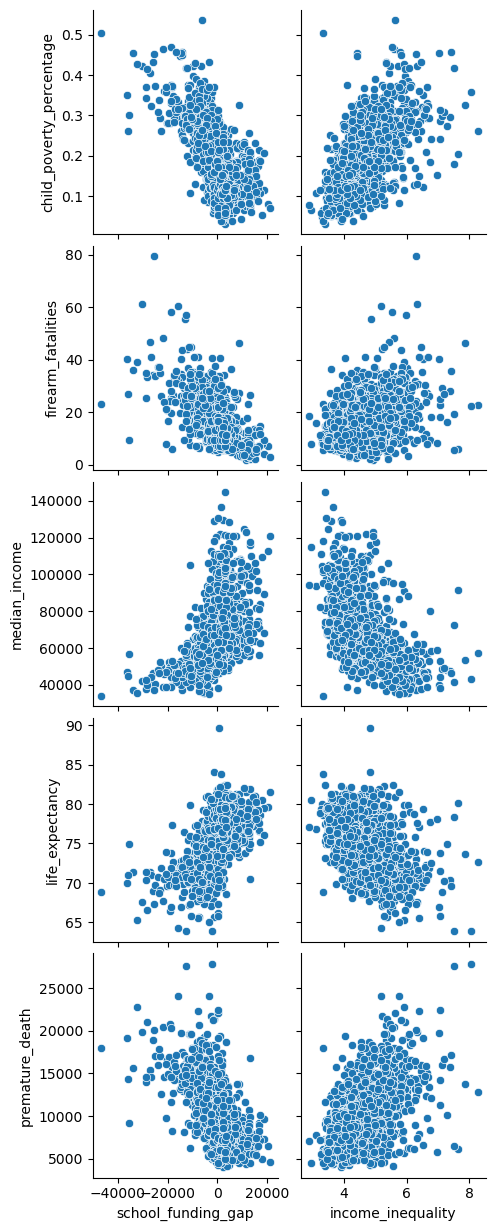

In [51]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    )     

## Distributions

In [ ]:
agg_select_subset.hist(figsize=(12,12), layout=(3,3), color='teal', ec='black', sharex=False);

In [ ]:
sns.displot(agg_select_subset['school_funding_gap'])

In [ ]:
sns.displot(agg_select_subset['income_inequality'])

**Note**: not normally distributed

## Variation in each variable

In [ ]:
ax = agg_select_subset[high_mutual_info_vars].plot(figsize=(20,15))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Drill down on race

In [ ]:
all_sets_raw = all_sets.dropna()
all_sets_raw.reset_index(inplace=True)

In [ ]:
#high_mutual_info_vars.remove('race')
race_high_val_mutual_info_vars = high_mutual_info_vars.copy()
race_high_val_mutual_info_vars.append('race')
race_select_subset = all_sets_raw[race_high_val_mutual_info_vars]

### Pair Plots

In [ ]:
sns.barplot(race_select_subset, x='race', y='premature_death')

In [ ]:
race_select_subset.groupby('race')['child_poverty_percentage'].median()

In [ ]:
sns.FacetGrid(data = race_select_subset, col = 'race').map(plt.scatter, 'school_funding_gap', 'child_poverty_percentage').add_legend()
plt.show()

In [ ]:
race_select_subset.columns

In [ ]:
sns.set_theme()

g = sns.lmplot(
    data=race_select_subset,
    x='school_funding_gap', y='firearm_fatalities', hue='race',
    height=5
)

g.set_axis_labels('school funding', 'firearm fatalities')

In [ ]:
sns.set_theme()

g = sns.lmplot(
    data=race_select_subset,
    x='school_funding_gap', y='child_poverty_percentage', hue='race',
    height=5
)

g.set_axis_labels('school funding', 'child poverty')

## Comparing distributions between inequality metric quantiles

In [ ]:
q1_school_funding = agg_select_subset['school_funding_gap'].quantile(.25)
q2_school_funding = agg_select_subset['school_funding_gap'].quantile(.5)
q3_school_funding = agg_select_subset['school_funding_gap'].quantile(.75)

In [ ]:
q1_income_inequality = agg_select_subset.groupby('county')['income_inequality'].quantile(.25)
q2_income_inequality = agg_select_subset.groupby('county')['income_inequality'].quantile(.5)
q3_income_inequality = agg_select_subset.groupby('county')['income_inequality'].quantile(.75)

## Political Party

In [ ]:
agg_select_subset.columns

## Regression

In [ ]:
X = agg_select_subset[['school_funding_gap', 'income_inequality']]
y = agg_select_subset[['premature_death']]
X_train, X_test,\
  y_train, y_test = train_test_split(X, y,
                    test_size=0.4,
                    random_state=1)
reg = linear_model.LinearRegression()
model1 = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_test['school_funding_gap'], X_test['income_inequality'],
           y_test, color='coral', alpha=0.7, label='Premature Death')

x1_range = np.linspace(X_test['school_funding_gap'].min(), X_test['school_funding_gap'].max(), 100)
x2_range = np.linspace(X_test['income_inequality'].min(), X_test['income_inequality'].max(), 100)
x1, x2 = np.meshgrid(x1_range, x2_range)

z = model.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

ax.plot_surface(x1, x2, z, color='aquamarine', alpha=0.4, rstride=100, cstride=100)

ax.set_xlabel('School Funding')
ax.set_ylabel('Income Inequality')
ax.set_zlabel('Premature Death')
ax.set_title('Multiple Linear Regression Best Fit Line (3D)')

plt.show()

In [ ]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

### Residual Errors

In [ ]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="orange", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="teal", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper left')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [ ]:
#regr = linear_model.LinearRegression()  
#model1= regr.fit(X, Y)

In [ ]:
#r2 = regr.score(X,Y)
#coefficients =regr.coef_
#intercept = regr.intercept_